# ADM - Homework 5 - Exploring StackOverflow!

## Group Members:
### Mohammad Mehdi Razavi - mohammadmehdirazavi97@gmail.com - 2023856
### Leonardo Skerl - skerl.1802968@studenti.uniroma1.it
###

# 1. Data

In [106]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import sklearn
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import networkx as nx
import datetime
from tqdm import tqdm
import heapq as heap

In [107]:
#this converts datetime in timestamps to create that subportion of the graph

def date_to_time(interval):
    start_string = datetime.datetime.strptime(interval[0], '%d/%m/%Y')
    start= int(datetime.datetime.timestamp(start_string))
    end_string = datetime.datetime.strptime(interval[1], '%d/%m/%Y')
    end= int(datetime.datetime.timestamp(end_string))
    return (start, end)

In [3]:
interval = ("13/12/2010","15/12/2010")

In [4]:
date_to_time(interval)

(1292194800, 1292367600)

In [5]:
def graph_reduced(interval, path, weight):

  #create a empty graph
  #G = nx.Graph() #another option..but it seems we need to build a directed graph
    G = nx.DiGraph()

  #setting the start and end give a date
    start = date_to_time(interval)[0]
    end = date_to_time(interval)[1]

  #add new edge's pair when there aren't those edges
  #otherwise add the weight to the existent edges 
  #(in practice works in the opposite way but the result is the same)
    with open(path, mode='r', encoding='UTF-8') as data:
        for row in data.readlines():
            feat = row.split(' ')
            if start <= int(feat[2]) and end>= int(feat[2]):
                if (feat[0], feat[1]) in G.edges():
                    G[feat[0]][feat[1]]['weight'] += weight
                else: 
                    G.add_edge(feat[0], feat[1], weight = weight, timestamps = feat[2])
    return(G)

In [6]:
#this create the final graph that must be utilizied for most of the queries
def merge_graphs(graphs1):
    graphs=graphs1.copy()
    for i in range(1,len(graphs)):
        for edges in graphs[i].edges(data = True):
            if (edges[0], edges[1]) in graphs[0].edges():
                graphs[0][edges[0]][edges[1]]['weight'] += edges[2]['weight']
            else:
                graphs[0].add_edge(edges[0], edges[1], weight = edges[2]['weight'])
    return(graphs[0])

In [7]:
graph_a2q = graph_reduced(interval,'sx-stackoverflow-a2q.txt', 1)

In [8]:
graph_c2a = graph_reduced(interval,'sx-stackoverflow-c2a.txt', 0.25)

In [9]:
graph_c2q = graph_reduced(interval,'sx-stackoverflow-c2q.txt', 0.5)

In [10]:
final = merge_graphs([graph_a2q, graph_c2a, graph_c2q])


# 2. Implementation of the backend

## Functionality 1 - Get the overall features of the graph

In this function, given a graph we compute the following elements:
- Number of Nodes = $ |nodes|$
- Number of Edges = $ |edges| $
- Average links for each node = $ \frac {|edges|}{|nodes|} $
- Density for Directed Graphs = $ \frac{|edges|}{|nodes|(|nodes|-1)} $
- Density for Undirected Graphs = $ \frac{2|edges|}{|nodes|(|nodes|-1)} $
- In this exercise we assume a graph with a density equal or bigger than 0.5 as "dense", otherwise is "sparse"

In [125]:
#all the stuff asked in question 2.1
def functional_1(graph):
    nodes = list()
    edges = list()
    for edge in graph.edges():
        nodes.append(edge[0])
        nodes.append(edge[1])
        edges.append(edge)
    nodes = set(nodes)
    edges = set(edges)
    n_nodes = len(nodes)                # compute number of nodes in graph
    n_edges = len(edges)                # compute number of edges in graph
    average = n_edges/n_nodes           # compute the average edges for all nodes in graph
    if nx.is_directed(graph):           # check if the graph is directed or undirected
        graph_type = 'Directed'
        dens = n_edges/((n_nodes)*(n_nodes-1)) # compute the density if the graph is directed
    else: 
        graph_type = 'Undirected'
        dens = (2*n_edges)/((n_nodes)*(n_nodes-1)) # compute the density if the graph is undirected
    if dens >= 0.5:                                # check if the graph is dense or sparse
        car = 'Dense'
    else: car = 'Sparse'
    return(graph_type, n_nodes, n_edges, round(average,6), round(dens,6), car)

In [12]:
functional_1(final)

('Directed', 11139, 22248, 1.997307, 0.000179, 'Sparse')

## Functionality 2 - Find the best users!

### Dijkstra Algorithm

In [126]:
#this is djikstra shortest path alghoritm, needed to calculate 
#the betweeness centrality and the closeness centrality

def dijkstra(graph, start):
    par = dict()
    visited = set()
    hp = list()
    nodes = defaultdict(lambda: float('inf')) 
    nodes[start] = 0
    heap.heappush(hp, (0, start))
    while hp:
        _, node = heap.heappop(hp)
        visited.add(node)

        for adjNode, weight in graph[node].items():
            weight = weight.get('weight')
            if adjNode in visited:	continue
            newCost = nodes[node] + weight
            if nodes[adjNode] > newCost:
                par[adjNode] = node
                nodes[adjNode] = newCost
                heap.heappush(hp, (newCost, adjNode))

    return par, nodes

From Dijkstra Algorithm we compute the path between two nodes: if there isn't a path the algorithm returns : "Not possible". \\
Notice that the algorithm returns "Not possible" also if you give in input nodes that don't exist in the graph

In [127]:
def path(graph, start, destination):
    p ,n = dijkstra(graph, start)
    if destination not in p.keys():
        return "Not possible"
    list_of_nodes=[]
    el=destination
    list_of_nodes.append(el)
    while p[el] != start:
        list_of_nodes.append(p[el])
        el= p[el]
    list_of_nodes.append(start)
    return (list_of_nodes[::-1], n[destination])

### Closeness Centrality

Closeness centrality for node u is given by: 
$ \frac{|nodes|-1}{\sum_{v=1}^{|nodes|-1}d(v,u)} $

In [128]:
# this function take as input the output of djikstra 
#to calculte the closeness centrality for that node
def closeness_centrality(graph, start):
    par, nodes=dijkstra(graph, start)
    numerator= len(nodes) - 1
    denominator=0
    for edge in nodes:
        denominator+=nodes[edge]
    closeness= numerator/denominator
    return round(closeness, 4)

In [109]:
closeness_centrality(final, '464552')

0.2183

### Degree Centrality

Degree Centrality for user u is give by: $ \frac{|neighbors(u)|}{|nodes|-1} $

In [129]:
#this calculate the degree centrality
def degree_centrality(user, graph):
    degree=len(list(graph.neighbors(user)))
    degree_centrality = degree/(len(graph.nodes())-1)
    return round(degree_centrality, 6)

In [64]:
degree_centrality('85385' , final)

0.00018

### Pagerank


First of all, to compute the pagerank, we create a weighted adjacency matrix normalized over the rows


In [130]:
def normalized_matrix(graph):
    a=nx.to_numpy_array(graph)
    sum_of_rows = a.sum(axis=1)
    for i in tqdm(range(len(a))):
        for j in range(len(a)):
            if sum_of_rows[i] == 0:
                a[i][j] = 0
            else: a[i][j] = a[i][j] / sum_of_rows[i]
    return a

Then we create a dictionary that given a node returns the position of it in the adjacency matrix

In [131]:
def dictionary_mapping(graph):
    diz = {}
    c = 0
    for el in list(graph.nodes):
        diz.update({el : c})
        c+=1
    return diz

Compute the pagerank for the user u, given an alpha and a max number of iterations

In [132]:
#this calculate the pagerank
def random_surfer(graph, alpha, T , user):
    adj_matrix=normalized_matrix(graph)
    n=len(graph.nodes())
    alpha_matrix = np.full((n, n), (alpha/n))
    adj_matrix=adj_matrix*(1-alpha)
    P= adj_matrix+alpha_matrix
    map_of_nodes=dictionary_mapping(graph)
    index=map_of_nodes[user]
    q_0=np.zeros(n)
    q_0[index]=1
    q_0=q_0.T
    P_t=np.linalg.matrix_power(P, T)
    q_t=np.dot(q_0, P_t)
    #q_t= np.dot(q_t, P[:, index])
    return q_t

In [139]:
q_t=random_surfer(final, 0.85, 100, '55142')

100%|████████████████████████████████████████████████████████████████████████████| 11139/11139 [01:52<00:00, 98.58it/s]


### Betweenness Centrality

Compute the betweenness centrality for node u using the formula: 
$ Betw(u) = \sum_{u \neq v \neq w} \frac{|paths \ that \ pass \ through \ u \ and \ w \ including \ node \ v|}{|paths \ that \ pass \ through \ u \ and \ w|} $

In [111]:
def betweenness_centr(graph, node):
    if node not in graph.nodes:
        return('Node not in the Graph')
    betwenes = 0
    number_of_not_connected_node=0
    N=len(graph.nodes())
    normalization=(N-1)*(N-2)
    for i in tqdm(graph.nodes):
        for j in graph.nodes:
            if i != j and i!= node and j != node:
                try:
                    a=list(nx.all_shortest_paths(graph_c2a, i, j, weight = 'weight'))
                    denominator=len(a)
                    numerator=0
                    for elem in a:
                        if node in elem:
                            numerator+=1
                    betwenes+=(numerator/denominator)
                except:
                    number_of_not_connected_node+=1
    return (round(betwenes/normalization,10))

### Effective Functionality 2

Functionality 2: given an interval of time, a node and a metric computes the given metric for the given node.
Choices are: 
- Closeness (for closeness centrality)
- Betweenness (for betweenness centrality)
- Pagerank (for pagerank)
- Degree  (for Degree Centrality)


In [112]:
#just the start of funciotn 2, this should be completed when we have the measuremnts for all the metrics
def functional_2(node, interval, metric):

    graph_a2q = graph_reduced(interval, 'sx-stackoverflow-a2q.txt', 1)
    graph_c2a = graph_reduced(interval, 'sx-stackoverflow-c2a.txt', 0.25)
    graph_c2q = graph_reduced(interval, 'sx-stackoverflow-c2q.txt', 0.5)
    graph = merge_graphs([graph_a2q, graph_c2a, graph_c2q])

    if metric == 'Closeness':
        return('Closeness Centrality for node ', node, ' = ', closeness_centrality(graph,node))

    if metric == 'Betweenness':
        return('Betweenness Centrality for node ', node, ' = ', betweenness_centr(graph, node))

    if metric == 'Degree':
        return('Degree Centrality for node ', node, ' = ', degree_centrality(node, graph))

    if metric == 'Pagerank':
        return('Pagerank for node with alpha = 0.85 and max-iter = 100 ', node, ' = ', random_surfer(graph, 0.85, 100, node))

## Functionality 3 - Shortest Ordered Route

Given an interval of time, a list of nodes to visit, and two nodes where to start and arrive, returns the shortest path that arrives in order to each node until the end node and the weight of the total path

In [34]:
def functional_3(interval, visit, start, end):
    graph_a2q = graph_reduced(interval, 'sx-stackoverflow-a2q.txt', 1)
    graph_c2a = graph_reduced(interval, 'sx-stackoverflow-c2a.txt', 0.25)
    graph_c2q = graph_reduced(interval, 'sx-stackoverflow-c2q.txt', 0.5)
    graph = merge_graphs([graph_a2q, graph_c2a, graph_c2q])
    
    p_short_all = []

    w = 0

    if path(graph, start, visit[0]) != 'Not possible':

        pat, weight = path(graph, start, visit[0])

        p_short_all = p_short_all + pat

        w += weight

        if len(visit)>1:

            for i in range(len(visit)-1):
                if path(graph, visit[i], visit[i+1]) != 'Not possible':
                    pat, weight = path(graph, visit[i], visit[i+1])
                    p_short_all = p_short_all + pat[1:]
                    w += weight
                else: return('Not possible')
      
        if path(graph, visit[-1], end) != 'Not possible':
            pat, weight = path(graph, visit[-1], end)

            p_short_all = p_short_all + pat[1:]

            w += weight
      
        else:
            print('Not possible')
            return (0,0)
    
    else: 
        print('Not possible')
        return (0, 0)

    return(p_short_all, w)

## Functionality 4 - Disconnecting graphs


In [105]:
def F4_disconnectingGrapsh(interval1,interval2):
    #implement functionality 4 
    
    # here we can choose between 3 datasets in the query interval
    # for better visualization we chose graph_c2q
    graph_a2q1 = graph_reduced(interval1, 'sx-stackoverflow-a2q.txt', 1)
    graph_c2a1 = graph_reduced(interval1, 'sx-stackoverflow-c2a.txt', 0.25)
    graph_c2q1 = graph_reduced(interval1, 'sx-stackoverflow-c2q.txt', 0.5)
    graph1 = graph_c2q1
    
    graph_a2q2 = graph_reduced(interval2, 'sx-stackoverflow-a2q.txt', 1)
    graph_c2a2 = graph_reduced(interval2, 'sx-stackoverflow-c2a.txt', 0.25)
    graph_c2q2 = graph_reduced(interval2, 'sx-stackoverflow-c2q.txt', 0.5)
    graph2 = graph_c2q2
    
    intersaction_node = [] 
    
    # find a user in graph1 that is not in the graph2
    for node in graph1.nodes():
        if not graph2.has_node(node):
            user1 = node
    # find a user in graph2 that is not in the graph1
    for node in graph2.nodes():
        if not graph1.has_node(node):
            user2 = node
        
    #search the node which are in the interesection
    for u in graph1:
        if graph2.has_node(u):
            intersaction_node.append(u)
    
    number_links_1 = 0
    weight_links_1 = 0
    number_links_2 = 0
    weight_links_2 = 0
    list_pair_1 = []
    list_pair_2 = []
    
    #disconnecting links from graph2
    for point in tqdm(intersaction_node):
        for _,checkPoint, attr in graph2.edges(point, data = True):
                list_pair_2.append((point, checkPoint))
                number_links_2 += 1
                weight_links_2 += attr['weight']
                
    #disconnecting links from graph1
    for point in tqdm(intersaction_node):
        for _,checkPoint, attr in graph1.edges(point, data = True):
                list_pair_1.append((point, checkPoint))
                number_links_1 += 1
                weight_links_1 += attr['weight']
    
    #return the number of lower links
    if(number_links_1 < number_links_2 ):
        return graph1, graph2, intersaction_node, list_pair_1
    else:
        return graph2, graph1, intersaction_node, list_pair_2


# 3. Implementation of the frontend

In this section, we ask you to build the visualizations for users’ queries results. We also expect you to showcase plots which can give us the most insight as possible and comment them accordingly.

## Visualization 1 - Visualize the overall features of the graph

Output a table with all of the information requested. The visualization should also generate a plot of the density distribution of the graph provided as input.

In [46]:
# take input for the query graph
query_graph = input("Input your chosen graph.\n1.Answer to question\n2.Comments to question\n3.Comments to answer\n4.Whole datasets")

if query_graph == '1':
    chosen_graph = graph_a2q
elif query_graph == '2':
    chosen_graph = graph_c2q
elif query_graph == '3':
    chosen_graph = graph_c2a
elif query_graph == '4':
    chosen_graph == final
else:
    print('wrong input')

# call function1 and print the information about the query graph
g_type,n_user,n_answer,avg_link,density,sparse = functional_1(chosen_graph)
print_info(chosen_graph)


Input your chosen graph.
1.Answer to question
2.Comments to question
3.Comments to answer
1
Information about chosen graph
Graph Type : Directed
Number of Users:11139
Number of answers/comments: 22248
Average Number of Links Per User: 1.997307
Density Degree of The Graph: 0.000179
Sparse Or Dens?: Sparse


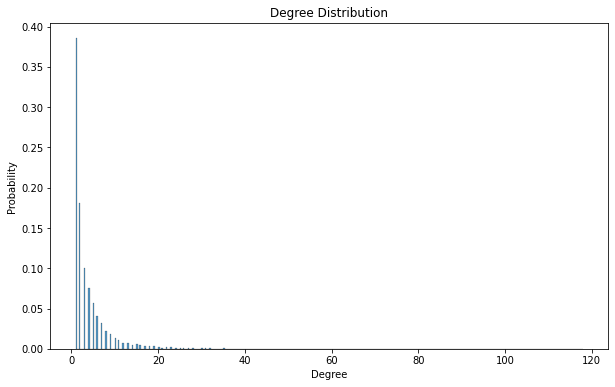

In [55]:
# make The density list and plot the distribution for query graph

density = [chosen_graph.degree(node) for node in chosen_graph.nodes.keys()]
plt.figure(figsize = (10,6))
plt.title('Degree Distribution')
plt.xlabel("Degree")
sns.histplot(density, stat="probability")
plt.show()

## Visualization 2 - Visualize the best user!
Plot the input node and a subset of its neighbouring nodes such that the user can get a grasp of the importance of this input node. Also split the interval of time into equidistant ranges of time and show the metric evolution over time.

In [122]:
def visualize2(chosen_graph, node, interval, metric):
    # visualize the query node and its neighbors
    
    sub_graph = [node] + list(chosen_graph.neighbors(node))
    sub = chosen_graph.subgraph(sub_graph)
    plt.figure(figsize = (10,8))
    plt.figure(1)
    plt.title(f'node {node} and its neighbours')
    nx.draw(sub, with_labels = True, alpha = 0.7)
    
def visualize2_2(graph,node,interval,metric, n=3):
    # show the metric evolution over time
    start_date = interval[0]
    end_date = interval[1]
    
    time_start = datetime.datetime.strptime(start_date, '%d/%m/%Y')
    time_end = datetime.datetime.strptime(end_date, '%d/%m/%Y')
    
    #calculate the periods of time we want
    diff = (time_end - time_start) // n
    
    time_periods = []
    for i in range(0,n):
        time_periods.append(time_start + i * diff)
    time_periods.append(time_end)

    res = []
    for i in range(len(time_periods)-1):
        interval_temp = (time_periods[i].strftime("%d/%m/%Y"), time_periods[i+1].strftime("%d/%m/%Y"))
        graph_temp = graph_reduced(interval_temp, 'sx-stackoverflow-a2q.txt', 1)
        if(metric == '1'):
            betweenness_centr(graph_temp, node)
        elif(metric == '2'):
            score = random_surfer(graph_temp, 0.85, 100 , node)
        elif(metric == '3'):
            score = closeness_centrality(graph_temp, node)
        elif(metric == '4'):
            score = degree_centrality(node , graph_temp)
                
        res.append(score)
        
    inn = [f'{[time_periods[i],time_periods[i+1]]}' for i in range(len(time_periods)-1)]
    plt.figure(2)
    plt.title('Score during time')
    plt.xticks(rotation=45, ha='right')
    plt.bar(inn, res)

select the node
68015
Input your chosen graph.
1.Answer to question
2.Comments to question
3.Comments to answer
1
input interval(dd/mm/yy dd/mm/yy)13/12/2010 16/12/2010
select the metric:
1.Betweeness
2.PageRank
3.ClosenessCentrality
4.DegreeCentrality
3


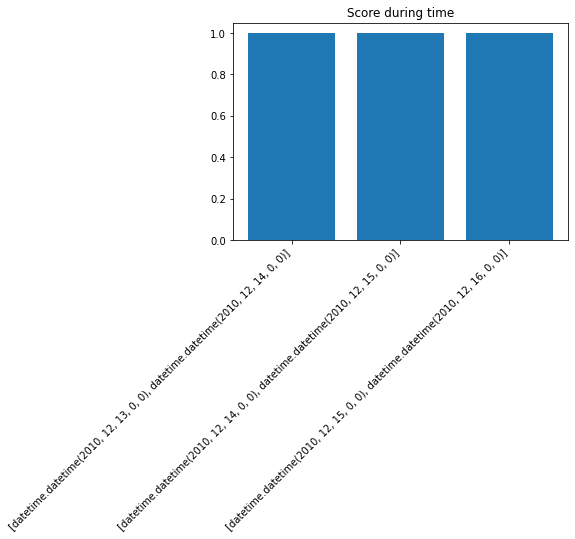

In [134]:
# take the query node
node = input("select the node\n") #68015
query_graph = input("Input your chosen graph.\n1.Answer to question\n2.Comments to question\n3.Comments to answer\n")

# 
if query_graph == '1':
    chosen_graph = graph_a2q
elif query_graph == '2':
    chosen_graph = graph_c2q
elif query_graph == '3':
    chosen_graph = graph_c2a

#take the query inter val
interval = input('input interval(dd/mm/yy dd/mm/yy)').split()

#take the query metric
metric = input("select the metric:\n" + \
              "1.Betweeness\n" +\
              "2.PageRank\n" +\
              "3.ClosenessCentrality\n" +\
              "4.DegreeCentrality\n")
n = 3
visualize2(chosen_graph, node, interval, metric)
visualize2_2(chosen_graph, node, interval, metric, n)

## Visualization 3 - Visualize the Shortest Ordered Route

Once the user runs Functionality 3, we want the system to show in output the Shortest Ordered Route.

In [103]:
def visualize3(interval,visit,start,end):
    result = functional_3(interval,visit,start,end)
    print('Shortest Ordered Route:', result)
    print('Start Node ; Red \nEnd Node: Green \nMust Visit Nodes: Blue')
    route = result[0]
    graph = nx.DiGraph()
    for i in range(len(route)-1):
        graph.add_edge(route[i],route[i+1])
    pos = nx.layout.spring_layout(graph)
    plt.tight_layout()
    plt.legend(scatterpoints = 1, markerscale = 0.4)
    color_map = ['red' if node == start else 'green' if node == end else 'blue' if node in visit else '#fff3b0' for node in graph]
    nx.draw(graph, with_labels = True, node_color=color_map, alpha = 0.7, pos = pos,arrowsize=15, connectionstyle='arc3,rad=0.05', node_size = 800)
    

In [104]:
visualize3(("04/03/2009","05/03/2009"),['16940','9314'],'19421','1585')

No handles with labels found to put in legend.


Shortest Ordered Route: (['19421', '16940', '9314', '73654', '73231', '29574', '33708', '15541', '3043', '16417', '72859', '1585'], 5.5)
Start Node ; Red 
End Node: Green 
Must Visit Nodes: Blue


## Visualization 4 - Visualize disconnecting graphs

Show a visualization of the links needed to be removed in order to disconnect both graphs.

For each of the visualization, you can add more 'fancy' stuff. Therefore, you can go deeper, adding more features, and making the visualization even more detailed! But, the important thing is that there are at least the requested features.

100%|█████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 64126.96it/s]


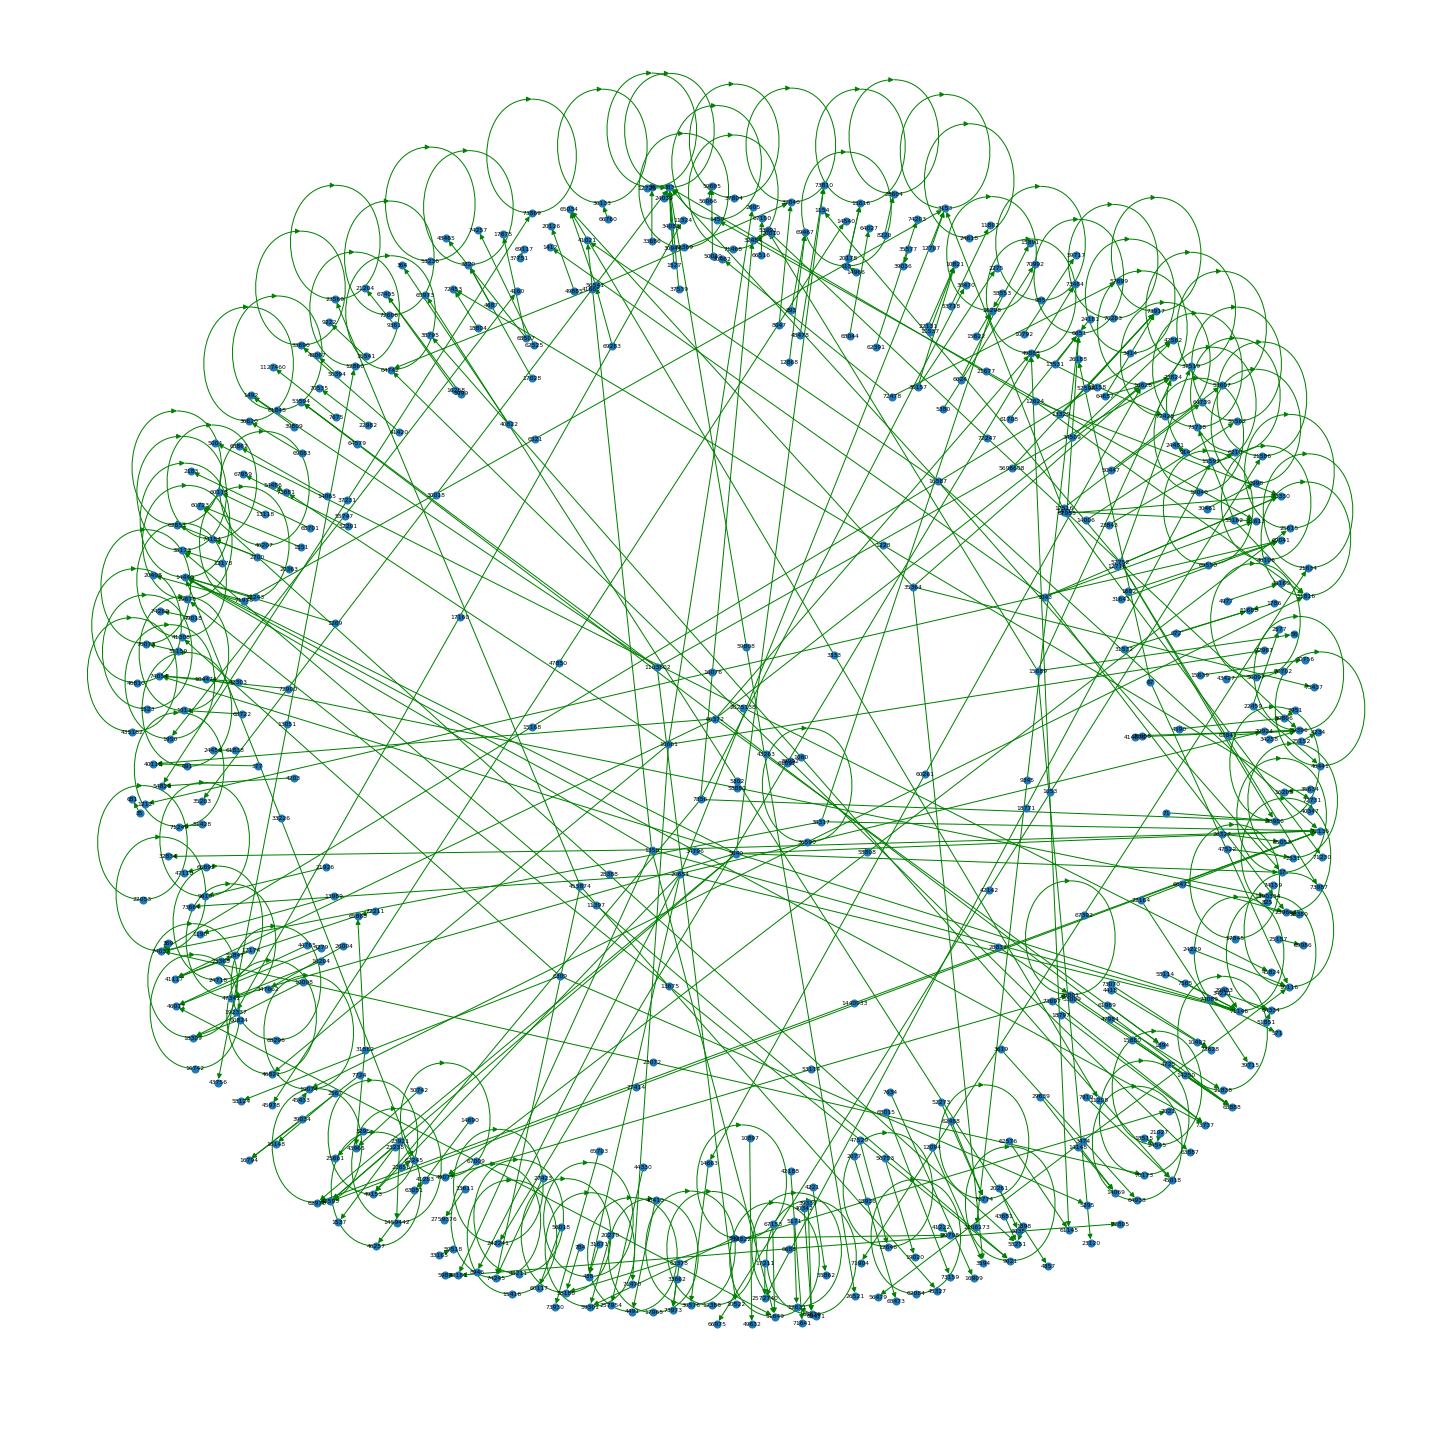

In [120]:
interval1 = ("04/03/2009","05/03/2009")
interval2 = ("05/03/2009","06/03/2009")
first, second, inter, couples = F4_disconnectingGrapsh(interval1, interval2)

plt.figure(figsize=(20,20))
nx.draw(first,with_labels = True, edge_color='red',node_size=50,font_size=6)
plt.show()

plt.figure(figsize=(20,20))
nx.draw(second,with_labels = True, edge_color='green',node_size=50,font_size=6)
plt.show()

plt.figure(figsize=(20, 20))
merge_graph = nx.compose(first, second)
pos = nx.spring_layout(merge_graph)
nx.draw(merge_graph,with_labels = True, pos=pos, edge_color='blue')
nx.draw_networkx_edges(merge_graph, pos=pos, edgelist=second.edges(data=True), edge_color='green')
nx.draw_networkx_nodes(merge_graph, nodelist=inter, node_color = 'red', pos=pos, node_size=1000)
nx.draw_networkx_edges(merge_graph, edgelist= couples, width=3.0,  pos=pos, edge_color='red')
plt.show()

# 4. Algorithmic question

The problem can simplified by representing evry children as a graph nodes and every K pairs of fighting children as and edge between them

In [116]:
from networkx.generators.random_graphs import gnp_random_graph
n = 20
p = 0.05
g = gnp_random_graph(n, p, seed= 400)

The algorithm starts from the first node and assigns it to 'dormitory1' list. The neighbours of the first node are then assigned to 'dormitory2' list. The second step is iterating through dormitory2 and check whether the neighbors of every children in it are already described in dormitory2. If they are, the outcome is not possible, in the other case the children are inserted in dormitory1. At the end of this section, the algorithm is set to replicate the iteration on dormitory1 with the same processes. 

In [117]:
def children_distribution(graph):
    dormitory1=set()
    dormitory2=set()
    child=list(graph.nodes())
    dormitory1.add(child[0])
    dormitory2.update(set(nx.neighbors(graph, child[0])))
    visited_nodes=[]
    visited_nodes.append(child[0])
    while len(visited_nodes) < len(graph.nodes):
        for el in dormitory2:
            fight=set(nx.neighbors(graph, el))
            for children in fight:
                if children in dormitory2:
                    return "No possible outcome"
                else: dormitory1.add(children)
            visited_nodes.append(el)
        for el2 in dormitory1:
            fight2=set(nx.neighbors(graph, el2))
            for children2 in fight2:
                if children2 in dormitory1:
                    return "No possible outcome"
                else: dormitory2.add(children2)
            visited_nodes.append(el2)
    return dormitory1 , dormitory2

In [118]:
children_distribution(g)

({0}, {17})